# Application of Population Predictive Checks (POP-PC) to Bayesian Models 

Due to recent developments in approximate posterior inference, Bayesian models have become much more easier to build. Therefore the assessment of the models are becoming a bigger concern. The paper Population Predictive Checks [Ranganath, Blei 2019] introduces an assessment framework called the POP-PC for Bayesian models, and show examples of applying it to the Dirichlet Process, Bayesian Linear Regression, and Latent Dirichlet Allocation. Since they have not proven the strength of POP-PCs for other Bayesian models such as Matrix Factorization (MF) and Gaussian Mixture Models (GMM), we have decided to test the POP-PC model assessment framework on these two models.

## Discrepancies

In PPCs (Posterior Predictive Checks, another model assessment framework) and POP-PCs, the predicted probability distribution is compared with a target distribution. Specifically, the target distribution for PPCs is the observed data (train data) and for POP-PCs it is the nonobserved data (test data). The comparison is conducted with the help of discrepancies, which are functions of the data that measures something that you want to see in the distributions (ex. mean, median, range, log-likelihood, etc.).

## Data

In our project, we use the MovieLens Dataset, which consists of ratings and metadata of movies. Specifically, we use the ratings_small.csv, which is a subset of the entire dataset. (subset consists of 100,000 ratings from 700 users on 9,000 movies)

### Import Relevant Packages

In [2]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle 

import util_pmf as util_pmf

from numpy.linalg import inv
from pyro import poutine
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

First, we are going to start with PMF, then GMM. (Note that we will use POP-PC and PPC at the very end of each model/section)

## Matrix Factorization (MF) using the MovieLens Dataset

In this section, we will use 3 different types of MF to predict the ratings of each users. MF is a technique to represent a given matrix with the product of two matrices. In our setting, one of matrices will represent users$\times$latent factors (matrix $u$), the other matrix will represent movies$\times$latent factors (matrix  $v$), and the product of those two matrices will represent the ratings of each movie given by the users. 

Note that we will only use movies that have more than 4 ratings.

### Data Preprocessing and Preparation

In [3]:
# For the following functions, set checker=0 when it is your
# first time running this preprocessing (creates files)
# Otherwise, set checker to any number when you
# already have those files
ratings_df = util_pmf.data_prepare_load(checker=1)
train_ratings, test_ratings = util_pmf.train_test_split(ratings_df, checker=1)
train_ratings = util_pmf.reindex_train(train_ratings, checker=1)
zero_imputated_ratings = util_pmf.zero_imputation(
    ratings_df, train_ratings, checker=1)
is_observed = (zero_imputated_ratings != 0)

### Distribution of Ratings (with more than 4 reviews)

#### Distribution of All Ratings

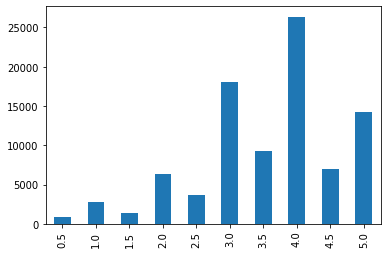

In [4]:
ratings_df['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

#### Distribution of Train Data Ratings

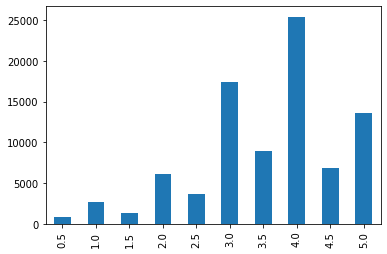

In [5]:
train_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

#### Distribution of Test Data Ratings

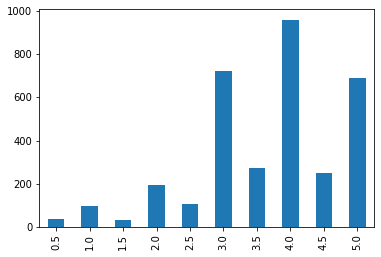

In [6]:
test_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

### Model: Probabilistic Matrix Factorization (PMF)

Now we implement the Probabilistic Matrix Factorization (PMF) model, which is the simplest "probabilistic" MF model. 

Given a rating matrix $R$,  user matrix $U$, movie matrix $V$, and variance $\sigma$, the likelihood of PMF is:

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where the user and feature vectors are given Gaussian priors:
\begin{equation}
    p(U|\mu_U, \sigma_U^2) = \prod_{i=1}^{N_U}N(U_i|\mu_U,\sigma_U^2I) \\
    p(V|\mu_V, \sigma_V^2) = \prod_{i=1}^{N_V}N(V_i|\mu_V,\sigma_V^2I)
\end{equation}

We set $\mu_U=\mu_V=0$ and $\sigma_U=\sigma_V=1$ here for simplicity.

For $k$ (represents latent factors of user and feature vectors), we chose $k=10$ for all MF models in this section.

In [7]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u, v.T), 1), obs=data)

### Inference

We use NUTS MCMC to approximate the posterior distribution of $p(u,v|R,\lambda, \mu, \sigma)$. Then we take the average of the sampled 100 $u^Tv$s as the predicted ratings of the movies given by users. Note that this is how inference is done for the rest of the MF section.

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [ ]:
# Run this when you do not have 'pmf_posterior_samples.pickle'
"""
with open('../data/pmf_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
rounded_estimate_ratings = util_pmf.calc_average_ratings(
                        posterior_samples['u'], posterior_samples['v'])
with open('../data/pmf_rounded_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

In [8]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using PMF and the distribution of the train and test data. Note that we will conduct POP-PC and PPC at the very end of this section.

#### Distribution of Estimated Ratings using PMF

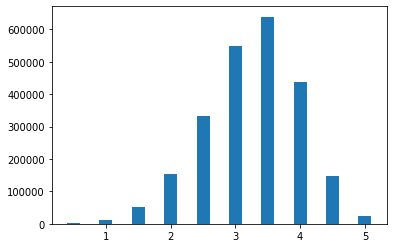

In [9]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Ratings Train Data

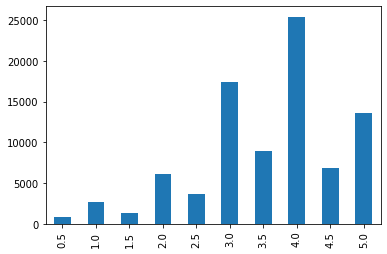

In [10]:
train_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]).plot(kind='bar')

#### Distribution of Ratings Test Data

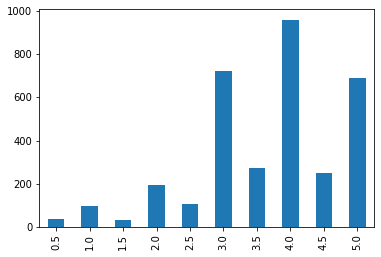

In [11]:
test_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]).plot(kind='bar')

- Compared to the train data, the entire predicted distribution is shifted towards the left side, where the mean of the training data is located. 
- Compared to the test data, the predictions are strongly underestimating movies with high rated movies.

To summarize, the PMF model can be thought to be overfitting by capturing the mean of the train data too strongly, preventing balanced predictions. The MAP objective may be causing these concentrated predictions.

### Model: Bayesian Probabilistic Matrix Factorization (BPMF)

In PMF, each user and movie had the same Normal distribution prior with constant mean and variance. In BMF, a prior distribution is set on the mean and variance of the Normal distributions of each user and each movie. This allows more flexibility in representing the different preferences of users and rating trends of movies using the decomposed matrices, producing more balanced predictions. 

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where
\begin{equation}
    p(U|\mu_U, \sigma_U^2) = \prod_{i=1}^{N_U}N(U_i|\mu_U,\sigma_U^2I) \\
    p(V|\mu_V, \sigma_V^2) = \prod_{i=1}^{N_V}N(V_i|\mu_V,\sigma_V^2I)
    
\end{equation}


\begin{equation}
    N(U_i|\mu_U, \sigma_U) N(V_j|\mu_V, \sigma_V)N(\mu, \sigma^2|\phi, \tau, \alpha, \beta)N(\phi, \tau)InvGam(\alpha,\beta)
\end{equation}

where a normal distribution with parameters $\phi$ and $\tau$ is the prior for $\mu$, and an inverse gamma distribution with parameteres $\alpha$ and $\beta$ is the prior for $\sigma^2$. Note that 

Here, we set $\phi=0$, $\tau=1$, $\alpha=1$, $\beta=1$.

In [12]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        with pyro.plate('user_k', k):
            p_u_mu = pyro.sample('p_u_mu', dist.Normal(0, 1))
            p_u_std = pyro.sample('p_u_std', dist.InverseGamma(1, 1))
            u = pyro.sample('u', dist.Normal(p_u_mu, p_u_std))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        with pyro.plate('movie_k', k):
            p_v_mu = pyro.sample('p_v_mu', dist.Normal(0, 1))
            p_v_std = pyro.sample('p_v_std', dist.InverseGamma(1, 1))
            v = pyro.sample('v', dist.Normal(p_v_mu, p_v_std))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u.T, v), 1), obs=data)

### Inference

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [13]:
# Run this when you do not have 'bpmf_posterior_samples.pickle'
"""
with open('../data/bpmf_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
rounded_estimate_ratings = util_pmf.calc_average_ratings(
posterior_samples['theta_u_k'], posterior_samples['beta_i_k'])
with open('../data/bpmf_rounded_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

"\nwith open('../data/bpmf_posterior_samples.pickle', 'wb') as handle:\n    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)\nrounded_estimate_ratings = util_pmf.calc_average_ratings(\nposterior_samples['theta_u_k'], posterior_samples['beta_i_k'])\nwith open('../data/bpmf_rounded_posterior_samples.pickle', 'wb') as handle:\n    pickle.dump(rounded_estimate_ratings, handle,\n    protocol=pickle.HIGHEST_PROTOCOL)\n"

In [14]:
with open('../data/bpmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using BPMF and PMF.

#### Distribution of Estimated Ratings using BPMF

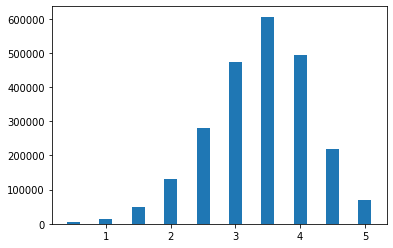

In [15]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using PMF

In [16]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

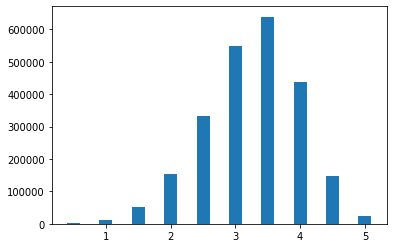

In [17]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

- The estimated ratings of BPMF are more spread out, having more weight on high rated movies.

Still, BPMF has a difference in the proportion of low and high ratings compared to the train and test data. This may have something to do with the assumed distribution that generates the ratings.

### Model: Poisson Matrix Factorization (PoiMF)

In PoiMF, a Poisson distribution is assumed to generate the ratings in the matrix. PoiMF has almost the same posterior distribution as the BPMF, except that the assumed distributions are Poisson and Gamma, with the hyperparameters corresponding to those distributions.

\begin{equation}
    p(R_{ij} | U_i, V_j, \Theta, \beta, a, b, c, d) = Poisson(R_{ij}|U_i, V_j, \Theta, \beta, a, b, c, d) Gamma(U_i|\Theta)Gamma(V_j|\beta)Gamma(\Theta| a, b)Gamma(\beta | c, d)
\end{equation}

where a Gamma distribution with parameters $a, b$  is the prior for $\Theta$ and a Gamma distribution with parameters $c, d$ is the prior for $\beta$. 

In [18]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        e_u = pyro.sample('e_u', dist.Gamma(1, 1))
        with pyro.plate('user_k', k):
            theta_u_k = pyro.sample('theta_u_k', dist.Gamma(1, e_u))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        n_i = pyro.sample('n_i', dist.Gamma(1, 1))
        with pyro.plate('movie_k', k):
            beta_i_k = pyro.sample('beta_i_k', dist.Gamma(1, n_i))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Poisson(torch.mm(
            theta_u_k.T, beta_i_k)), obs=data)

### Inference

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=1, warmup_steps=1)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [ ]:
# Run this when you do not have 'poissonmf_posterior_samples.pickle'
"""
#with open('../data/poissonmf_posterior_samples.pickle', 'wb') as handle:
    #pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
#rounded_estimate_ratings = util_pmf.calc_average_ratings(
posterior_samples['theta_u_k'], posterior_samples['beta_i_k'])
#with open('../data/poissonmf_rounded_posterior_samples.pickle',
'wb') as handle:
    #pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

In [19]:
with open('../data/poissonmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using PoiMF, BPMF,and PMF.

#### Distribution of Estimated Ratings using PoiMF

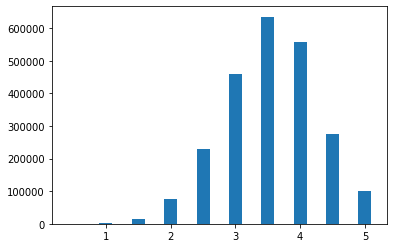

In [20]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using BPMF

In [21]:
with open('../data/bpmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

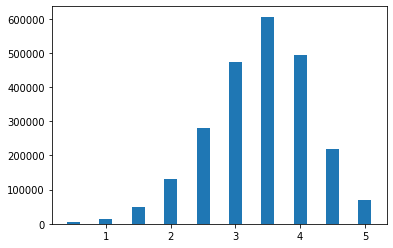

In [22]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using PMF

In [23]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

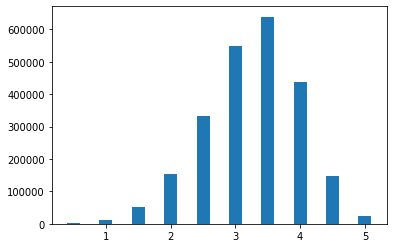

In [24]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

- The PoiMF has more high rating estimates compared to BPMF and PMF (closer to the mode of the ratings of the train data).
- PoiMF does not consider the lower ratings as much compared to BPMF and PMF.

### Criticism using POP-PC and PPC

We use the following simple discrepancies for the POP-PC and PPC for MFs.
- Mean, Median, First Quantile, and Third Quantile

In [30]:
ppc_mean, ppc_median, ppc_first_q, ppc_third_q, \
    poppc_mean, poppc_median, poppc_first_q, poppc_third_q \
    = util_pmf.model_assessment(train_ratings, test_ratings)

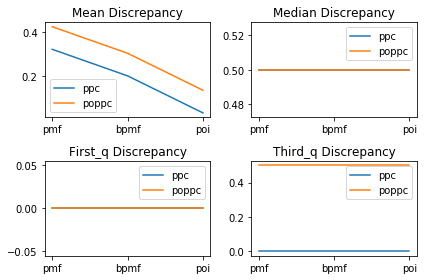

In [31]:
util_pmf.plot_poppc_ppc(ppc_mean, ppc_median,
                        ppc_first_q, ppc_third_q,
                        poppc_mean, poppc_median,
                        poppc_first_q, poppc_third_q)

### References

- Population Predictive Checks https://arxiv.org/abs/1908.00882
- MovieLens Dataset https://www.kaggle.com/rounakbanik/the-movies-dataset
- Probabilistic Matrix Factorization https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf
- Bayesian Probabilistic Matrix Factorization using Markov Chain Monte Carlo https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf
- Scalable Recommendation with Poisson Factorization https://arxiv.org/pdf/1311.1704.pdf
- NUTS http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf